In [1]:
import pandas as pd
import numpy as np
import math
import sys
import os
from IPython.display import display
from itertools import combinations
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import wilcoxon, friedmanchisquare, rankdata
from Orange.evaluation import compute_CD, graph_ranks

sys.path.append('../Algoritmos')
from multicriteria import GaussianAHP, MCPM, Traditional

criteria = ['f1_macro', 'ratio_f1_macro', 'ratio_selection_rate', 'ratio_recall', 'ratio_odds']

In [2]:
def results():
    measures = ['f1_macro', 'ratio_f1_macro', 'ratio_selection_rate', 'ratio_recall', 'ratio_odds']
    df = pd.DataFrame(columns = ['Dataset', 'Config', 'Selection'] + measures)
    count = 0

    for name in ['adult', 'arrhythmia', 'bank', 'compasmen', 'compaswomen', 
                 'contraceptive', 'heroin', 'nicotine', 'student', 'titanic']:    
        for config in ['dt', 'knn', 'mlp', 'rf', 'svm']:
            if os.path.exists('../Experimentos/' + name + '_' + config + '_validation.csv'):
                validation = pd.read_csv('../Experimentos/' + name + '_' + config + '_validation.csv', 
                                         sep=';', index_col=0)
                validation['ratio_odds'] = (validation['ratio_fpr'] + validation['ratio_recall'])/2
                validation['AHP'] = list(GaussianAHP(criteria).calculate(validation))
                validation['MCPM'] = list(MCPM(criteria).calculate(validation))
                validation['Traditional'] = list(Traditional(criteria).calculate(validation))

                test = pd.read_csv('../Experimentos/' + name + '_' + config + '_test.csv', sep=';', index_col=0)
                test['ratio_odds'] = (test['ratio_fpr'] + test['ratio_recall'])/2 

                idx_AHP = validation['AHP'].idxmax()
                idx_MCPM = validation['MCPM'].idxmax()
                idx_Traditional = validation['Traditional'].idxmax()
                idx_Single = validation['ratio_recall'].idxmax()

                ahp = []
                mcpm = []
                trad = []
                single = []

                ahp.append(name)
                mcpm.append(name)
                trad.append(name)
                single.append(name)

                ahp.append(config)
                mcpm.append(config)
                trad.append(config)
                single.append(config)

                ahp.append('AHP Gaussiano')
                mcpm.append('MCPM')
                trad.append('Tradicional')
                single.append('Single')

                for measure in measures:
                    ahp.append(test.loc[idx_AHP, measure])
                    mcpm.append(test.loc[idx_MCPM, measure])
                    trad.append(test.loc[idx_Traditional, measure])
                    single.append(test.loc[idx_Single, measure])

                df.loc[count] = ahp 
                count += 1
                df.loc[count] = mcpm 
                count += 1
                df.loc[count] = trad
                count += 1
                #df.loc[count] = single
                #count += 1
                
    return df

In [64]:
def cd(results, name):
    # ajusta a entrada de dados para o teste
    df = results[['AHP Gaussiano', 'MCPM', 'Tradicional']]
    algorithms_names = df.columns
    results_array = df.values

    # calcula os ranks
    ranks_test = np.array([rankdata(-p) for p in results_array])

    # calcula a média dos ranks
    average_ranks = np.mean(ranks_test, axis=0)
    print('\n'.join('({}) Média dos ranks: {}'.format(a, r) for a, r in zip(algorithms_names, average_ranks)))
    
    # This method computes the critical difference for Nemenyi test
    cd = compute_CD(average_ranks, n=len(df), alpha='0.05', test='nemenyi')
    print('CD = ', cd)
    # This method generates the plot.
    graph_ranks(average_ranks, names=algorithms_names, cd=cd, width=4, textspace=1.25, reverse=False, 
                filename = name + '.png')

## Reports

In [65]:
df = results()
df.groupby(by=['Config', 'Selection']).mean()


/tmp/ipykernel_11031/2987410076.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df.groupby(by=['Config', 'Selection']).mean()


f1_macro  ratio_f1_macro  ratio_selection_rate  \
Config Selection                                                       
dt     AHP Gaussiano  0.672092        0.903017              0.698996   
       MCPM           0.672830        0.884457              0.689454   
       Tradicional    0.672830        0.884457              0.689454   
knn    AHP Gaussiano  0.640157        0.924732              0.695025   
       MCPM           0.642994        0.926981              0.680285   
       Tradicional    0.642994        0.926981              0.680285   
mlp    AHP Gaussiano  0.695708        0.901177              0.708451   
       MCPM           0.695405        0.903192              0.703464   
       Tradicional    0.695386        0.903621              0.717222   
rf     AHP Gaussiano  0.704513        0.936381              0.638167   
       MCPM           0.704211        0.936375              0.638501   
       Tradicional    0.704211        0.936375              0.638501   
svm    AHP Gaussiano  0.655827        0.916963              0.671264   
       MCPM           0.654121        0.913206              0.670079   
       Tradicional    0.654265        0.905323              0.668251   

                      ratio_recall  ratio_odds  
Config Selection                                
dt     AHP Gaussiano      0.794519    0.696899  
       MCPM               0.766960    0.685643  
       Tradicional        0.766960    0.685643  
knn    AHP Gaussiano      0.769629    0.661333  
       MCPM               0.782528    0.649105  
       Tradicional        0.782528    0.649105  
mlp    AHP Gaussiano      0.841087    0.705292  
       MCPM               0.830163    0.697739  
       Tradicional        0.822094    0.686741  
rf     AHP Gaussiano      0.812957    0.684113  
       MCPM               0.813223    0.684670  
       Tradicional        0.813223    0.684670  
svm    AHP Gaussiano      0.764614    0.634908  
       MCPM               0.766098    0.634013  
       Tradicional        0.764328    0.631995

In [66]:
df.groupby(by=['Dataset', 'Selection']).mean()

/tmp/ipykernel_11031/1974995436.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df.groupby(by=['Dataset', 'Selection']).mean()


f1_macro  ratio_f1_macro  ratio_selection_rate  \
Dataset       Selection                                                       
adult         AHP Gaussiano  0.779702        0.980332              0.330920   
              MCPM           0.779098        0.980322              0.331587   
              Tradicional    0.779098        0.980322              0.331587   
arrhythmia    AHP Gaussiano  0.668020        0.883248              0.809726   
              MCPM           0.668020        0.883248              0.809726   
              Tradicional    0.667983        0.884107              0.837244   
bank          AHP Gaussiano  0.701598        0.923557              0.549582   
              MCPM           0.706448        0.929183              0.500102   
              Tradicional    0.706448        0.929183              0.500102   
compasmen     AHP Gaussiano  0.628617        0.967078              0.703775   
              MCPM           0.628617        0.967078              0.703775   
              Tradicional    0.628617        0.967078              0.703775   
compaswomen   AHP Gaussiano  0.596800        0.910331              0.876299   
              MCPM           0.596800        0.910331              0.876299   
              Tradicional    0.596800        0.910331              0.876299   
contraceptive AHP Gaussiano  0.656421        0.972471              0.928752   
              MCPM           0.656421        0.972471              0.928752   
              Tradicional    0.656421        0.972471              0.928752   
heroin        AHP Gaussiano  0.532750        0.859660              0.572245   
              MCPM           0.534443        0.825443              0.563185   
              Tradicional    0.534443        0.825443              0.563185   
nicotine      AHP Gaussiano  0.540880        0.857012              0.962424   
              MCPM           0.537468        0.849498              0.960055   
              Tradicional    0.537468        0.849498              0.960055   
student       AHP Gaussiano  0.816377        0.876579              0.912713   
              MCPM           0.816377        0.876579              0.912713   
              Tradicional    0.816377        0.876579              0.912713   
titanic       AHP Gaussiano  0.815430        0.934271              0.177370   
              MCPM           0.815430        0.934271              0.177370   
              Tradicional    0.815718        0.918504              0.173714   

                             ratio_recall  ratio_odds  
Dataset       Selection                                
adult         AHP Gaussiano      0.846476    0.555521  
              MCPM               0.847008    0.556636  
              Tradicional        0.847008    0.556636  
arrhythmia    AHP Gaussiano      0.827871    0.733047  
              MCPM               0.827871    0.733047  
              Tradicional        0.811734    0.711050  
bank          AHP Gaussiano      0.888954    0.710413  
              MCPM               0.894035    0.661842  
              Tradicional        0.894035    0.661842  
compasmen     AHP Gaussiano      0.783951    0.746044  
              MCPM               0.783951    0.746044  
              Tradicional        0.783951    0.746044  
compaswomen   AHP Gaussiano      0.866851    0.798480  
              MCPM               0.866851    0.798480  
              Tradicional        0.866851    0.798480  
contraceptive AHP Gaussiano      0.959908    0.910315  
              MCPM               0.959908    0.910315  
              Tradicional        0.959908    0.910315  
heroin        AHP Gaussiano      0.379688    0.421874  
              MCPM               0.323437    0.408372  
              Tradicional        0.323437    0.408372  
nicotine      AHP Gaussiano      0.937458    0.923835  
              MCPM               0.940425    0.922046  
              Tradicional        0.940425    0.922046  
student       AHP Gaussiano      0.974058   

In [67]:
df.groupby(by=['Selection']).mean()

/tmp/ipykernel_11031/4116396812.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df.groupby(by=['Selection']).mean()


,f1_macro,ratio_f1_macro,ratio_selection_rate,ratio_recall,ratio_odds
Selection,,,,,
AHP Gaussiano,0.673659,0.916454,0.682381,0.796561,0.676509
MCPM,0.673912,0.912842,0.676357,0.791794,0.670234
Tradicional,0.673937,0.911351,0.678743,0.789826,0.667631


## Statistical test

In [68]:
def statistical(measure):

    df_statistical = pd.DataFrame(columns = ['AHP Gaussiano', 'MCPM', 'Tradicional'])

    count = 0

    for name in ['adult', 'arrhythmia', 'bank', 'compasmen', 'compaswomen', 
                 'contraceptive', 'heroin', 'nicotine', 'student', 'titanic']:    
        for config in ['dt', 'knn', 'mlp', 'rf', 'svm']:

            validation = pd.read_csv('../Experimentos/' + name + '_' + config + '_validation.csv', sep=';', index_col=0)
            validation['ratio_odds'] = (validation['ratio_fpr'] + validation['ratio_recall'])/2
            validation['ratio_odds'] = (validation['ratio_fpr'] + validation['ratio_recall'])/2
            validation['AHP Gaussiano'] = list(GaussianAHP(criteria).calculate(validation))
            validation['MCPM'] = list(MCPM(criteria).calculate(validation))
            validation['Tradicional'] = list(Traditional(criteria).calculate(validation))

            test = pd.read_csv('../Experimentos/' + name + '_' + config + '_test.csv', sep=';', index_col=0)
            test['ratio_odds'] = (test['ratio_fpr'] + test['ratio_recall'])/2

            idx_AHP = validation['AHP Gaussiano'].idxmax()
            idx_MCPM = validation['MCPM'].idxmax()
            idx_Traditional = validation['Tradicional'].idxmax()
            #idx_Single = validation['ratio_recall'].idxmax()

            df_statistical.loc[count] = [test.loc[idx_AHP, measure], test.loc[idx_MCPM, measure],
                                  test.loc[idx_Traditional, measure]]
            count += 1
    return df_statistical

(AHP Gaussiano) Média dos ranks: 1.96
(MCPM) Média dos ranks: 2.02
(Tradicional) Média dos ranks: 2.02
CD =  0.4687402


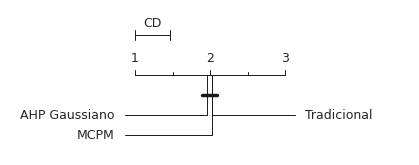

In [69]:
# f1_macro
sns.set(font_scale=0.75)
df_statistical = statistical('f1_macro')
cd(df_statistical, 'cd_f1_macro')

(AHP Gaussiano) Média dos ranks: 1.96
(MCPM) Média dos ranks: 2.02
(Tradicional) Média dos ranks: 2.02
CD =  0.4687402


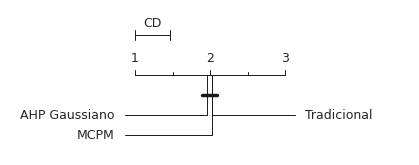

In [70]:
# ratio f1_macro
df_statistical = statistical('ratio_f1_macro')
cd(df_statistical, 'cd_ratio_f1_macro')

(AHP Gaussiano) Média dos ranks: 1.92
(MCPM) Média dos ranks: 2.04
(Tradicional) Média dos ranks: 2.04
CD =  0.4687402


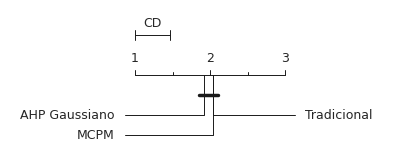

In [71]:
# demographic parity
df_statistical = statistical('ratio_selection_rate')
cd(df_statistical, 'cd_demographic_parity')

(AHP Gaussiano) Média dos ranks: 2.02
(MCPM) Média dos ranks: 1.96
(Tradicional) Média dos ranks: 2.02
CD =  0.4687402


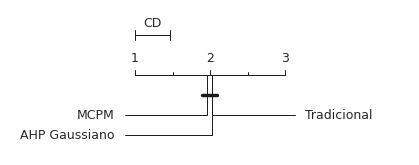

In [72]:
# equal opportunity
df_statistical = statistical('ratio_recall')
cd(df_statistical, 'cd_recall')

(AHP Gaussiano) Média dos ranks: 1.9
(MCPM) Média dos ranks: 2.02
(Tradicional) Média dos ranks: 2.08
CD =  0.4687402


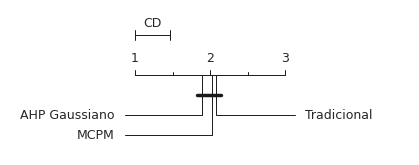

In [73]:
# equalized odds
df_statistical = statistical('ratio_odds')
cd(df_statistical, 'cd_odds')

## Visualization

In [13]:
new_df = df.groupby(by=['Dataset', 'Config', 'Selection']).mean().reset_index()
df_visualization = pd.DataFrame(columns = ['Algorithm', 'Seleção de Modelo', 'Measure', 'Value'])

count = 0
for row in new_df.iterrows():
    for measure in ['f1_macro', 'ratio_f1_macro', 'ratio_selection_rate', 'ratio_recall', 'ratio_odds']:
        df_visualization.loc[count] = [row[1]['Config'], row[1]['Selection'], measure, row[1][measure]]
        count += 1

In [14]:
def chart(metric, ylim, ylabel, legend):


    df_visualization1 = df_visualization.loc[df_visualization['Measure'] == metric]

    sns.set(style="ticks")
    sns.set(font_scale=2.4)
    sns.set_style("whitegrid")

    g = sns.catplot(
        data=df_visualization1, x='Algorithm', y='Value', width=0.75, #showmeans=True, showfliers = False, 
        legend=legend, legend_out=True, errorbar = None, 
        #meanprops={"marker":"o","markerfacecolor":"black", "markeredgecolor":"black"},
        hue='Seleção de Modelo' , kind='bar', palette='Pastel2', height=5, aspect=6,
    )

    g.set_xticklabels(['CART', 'KNN', 'MLP', 'RF', 'SVM'])
    g.set(xlabel=None)
    g.set(ylabel=ylabel)
    g.set(title=None)
    g.set(ylim=ylim)

    sns.despine(trim=True, offset=10)
    g.tight_layout()

    g.savefig(metric + '.png')

### F1 Macro

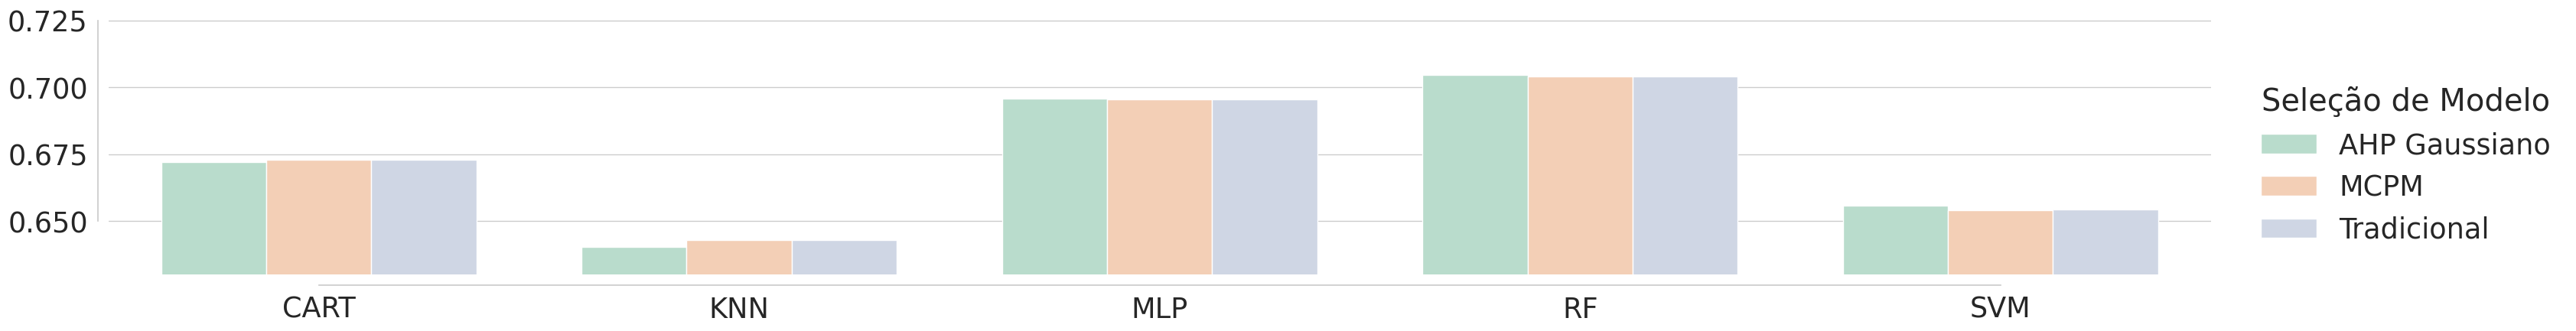

In [15]:
chart('f1_macro', (0.63, 0.73), None, True)

### RR - F1 Macro

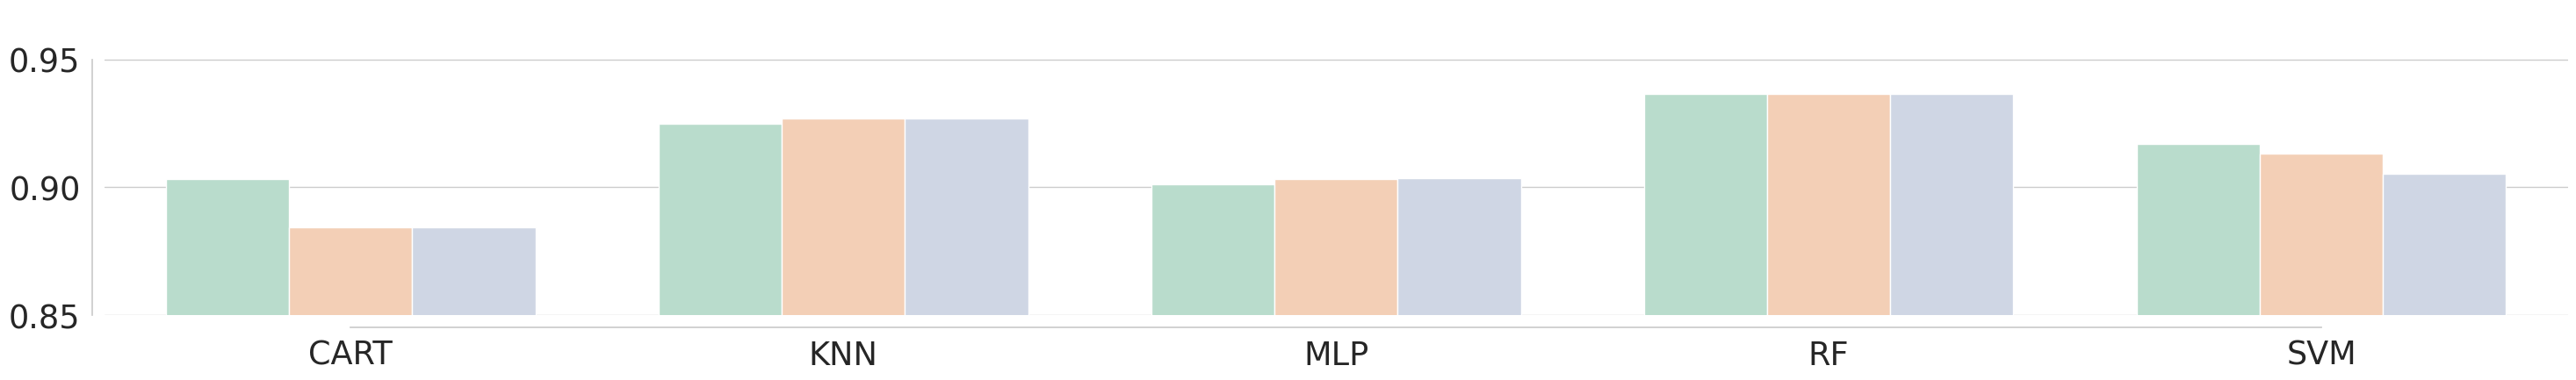

In [16]:
chart('ratio_f1_macro', (0.85, 0.97), None, False)

### Paridade Demográfica

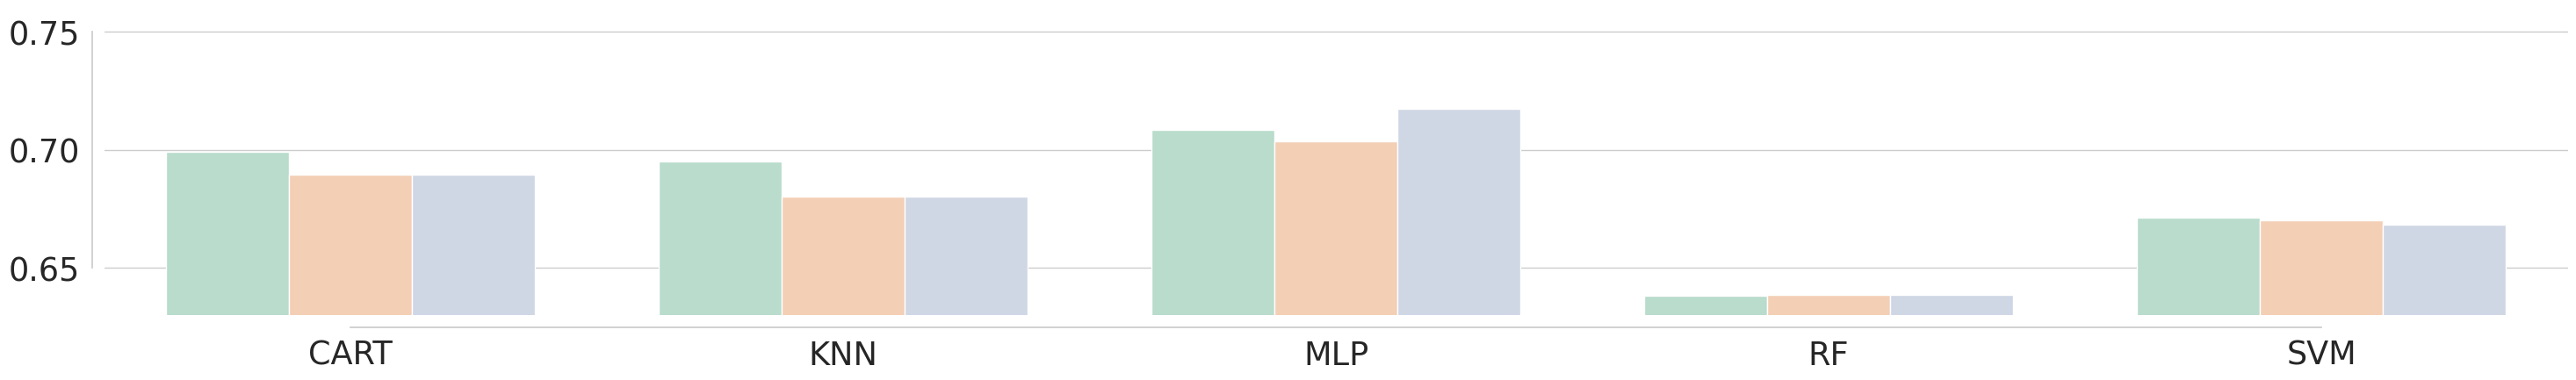

In [17]:
chart('ratio_selection_rate', (0.63, 0.76), None, False)

### Igualdade de Oportunidades

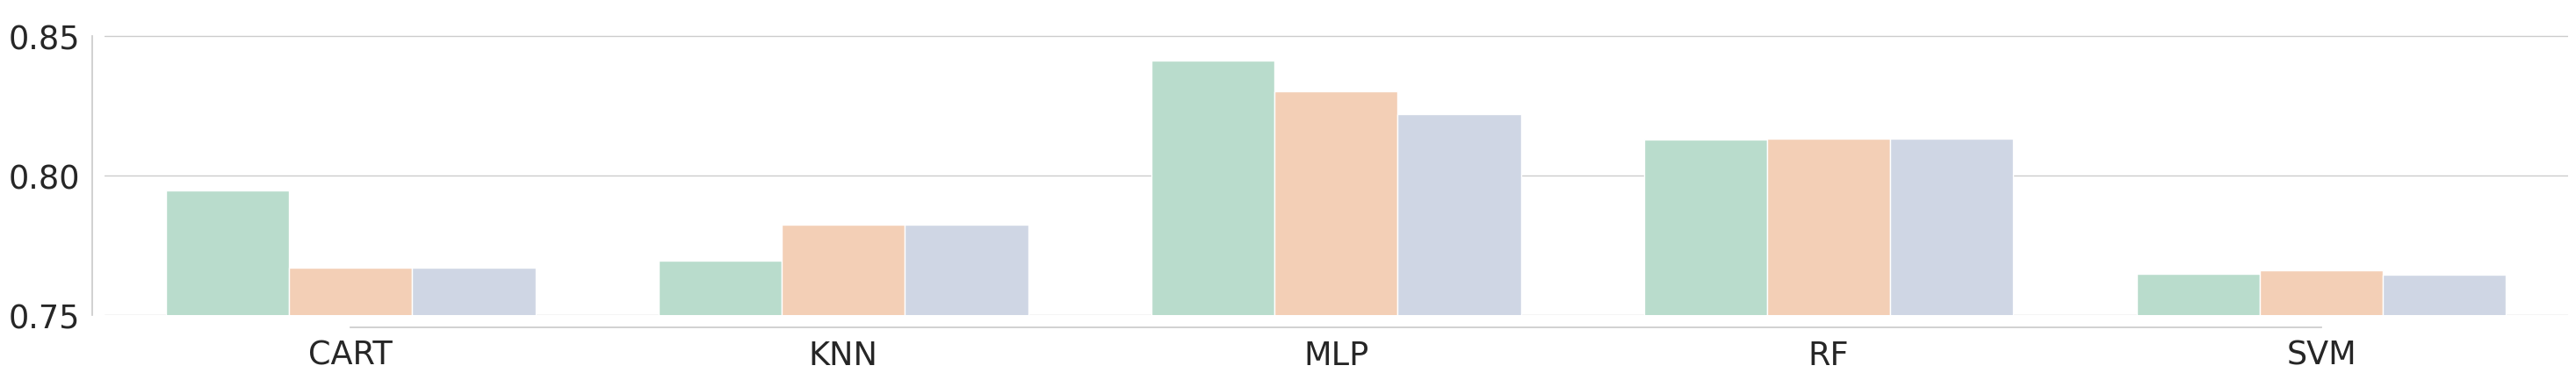

In [18]:
chart('ratio_recall', (0.75, 0.86), None, False)

### Probabilidades Equalizadas

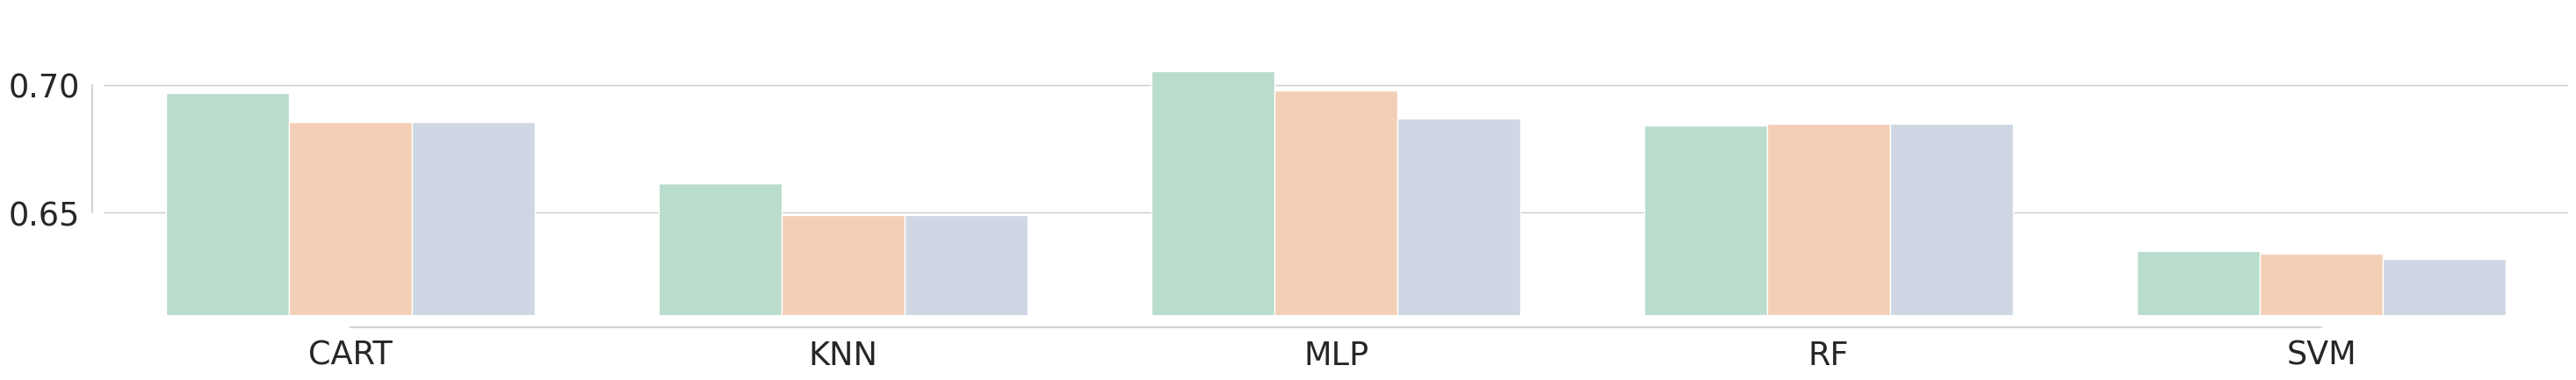

In [19]:
chart('ratio_odds', (0.61, 0.73), None, False)